## Preprocessing

In [1]:
import json

with open("data/palettes.json", "r", encoding="utf-8") as f:
    palettes = json.load(f)

In [2]:
from everyday_palette import Palette

palettes = [Palette.from_hex_list(p) for p in palettes]

In [3]:
from everyday_palette.processor import Processor
from sklearn.preprocessing import StandardScaler

processor = Processor(StandardScaler())
data = processor.fit_transform(palettes, 'oklab')
processor.save('scaler.joblib')

## Helper

In [4]:
from PIL import Image
from everyday_palette.palette import palette_to_png

def draw_palettes(palettes, w=200, h=50, ncols=5, margin=20, bg="white"):
    """
    Рисует сетку палитр на белом холсте.

    Parameters
    ----------
    palettes : list
        Список палитр (каждая поддерживает метод .to_img(w, h)).
    w, h : int
        Размер одной палитры.
    ncols : int
        Количество колонок в сетке.
    margin : int
        Отступ между палитрами.
    bg : str
        Цвет фона (по умолчанию "white").
    """
    n = len(palettes)
    nrows = (n + ncols - 1) // ncols

    # размеры холста
    grid_w = ncols * w + (ncols + 1) * margin
    grid_h = nrows * h + (nrows + 1) * margin
    canvas = Image.new("RGB", (grid_w, grid_h), bg)

    for i, pal in enumerate(palettes):
        row, col = divmod(i, ncols)
        x = margin + col * (w + margin)
        y = margin + row * (h + margin)
        img = palette_to_png(pal,w, h)
        canvas.paste(img, (x, y))

    return canvas

## Train GMM

In [5]:
from everyday_palette.generator.gmm import GMMGenerator

generator = GMMGenerator({'n_components':15})
generator.train(data)
generator.save('gmm')

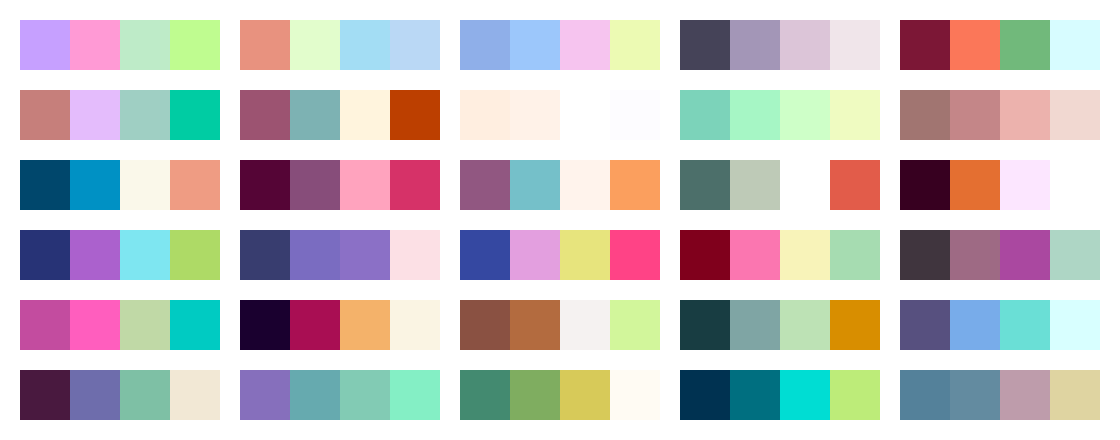

In [6]:
samples = generator.sample(30)
palettes = processor.inverse_transform(samples, 'oklab')
img = draw_palettes(palettes, w=200, h=50, ncols=5, margin=20)
img

## Train VAE

In [7]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, input_size, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 32)
        self.fc4 = nn.Linear(32, 64)
        self.fc5 = nn.Linear(64, input_size)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        h = torch.relu(self.fc4(h))
        return self.fc5(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [8]:
from everyday_palette.generator.vae import VAEGenerator

generator = VAEGenerator(VAE, {'latent_dim':8})
generator.train(data, 100)
generator.save('vae')

Epoch 000 | Train loss: 46049.7482
Epoch 010 | Train loss: 30034.3105
Epoch 020 | Train loss: 29344.5360
Epoch 030 | Train loss: 28873.3405
Epoch 040 | Train loss: 28854.3505
Epoch 050 | Train loss: 28748.3240
Epoch 060 | Train loss: 28709.4560
Epoch 070 | Train loss: 28438.0096
Epoch 080 | Train loss: 28540.3158
Epoch 090 | Train loss: 28593.3559


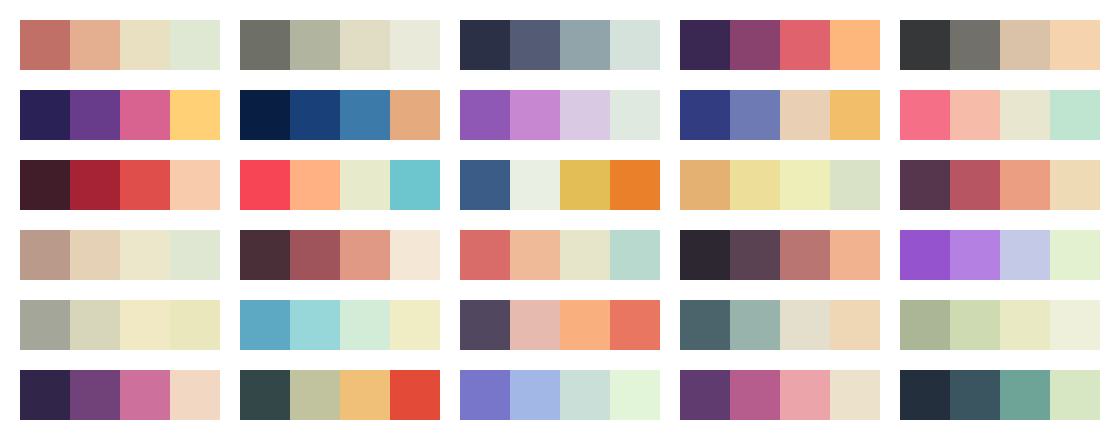

In [15]:
samples = generator.sample(30)
palettes = processor.inverse_transform(samples, 'oklab')
img = draw_palettes(palettes, w=200, h=50, ncols=5, margin=20)
img